# GMM-Based Synthetic Sampling for Imbalanced Data

**DA5401 Assignment 4**

This notebook implements a Gaussian Mixture Model (GMM) based synthetic sampling approach to address class imbalance in datasets. We will load the dataset, analyze it, implement GMM for synthetic data generation, and evaluate the performance of a model trained on the synthetic data.

## 1. Load and Analyze the Dataset

We begin by loading the dataset and performing initial analysis to understand its structure and class distribution.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('creditcard.csv')

# Display the first few rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# Check for missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## 2. Analyze Class Distribution

Let's calculate the counts of fraudulent vs. non-fraudulent transactions and visualize the class distribution.

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


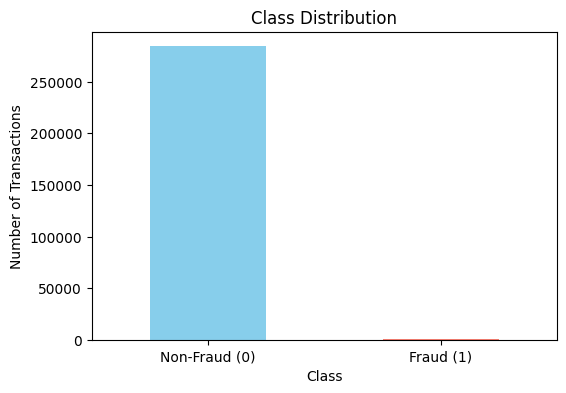

In [3]:
# Count of each class
class_counts = df['Class'].value_counts()
print("Class distribution:\n", class_counts)

# Bar plot
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Number of Transactions')
plt.show()

## 3. Split Data into Training and Test Sets

We split the dataset into training and test sets using stratified sampling to preserve class distribution.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

Training set class distribution:
 Class
0    199020
1       344
Name: count, dtype: int64
Test set class distribution:
 Class
0    85295
1      148
Name: count, dtype: int64


## 4. Train Baseline Logistic Regression Model

We train a Logistic Regression classifier on the imbalanced training data.

In [5]:
from sklearn.linear_model import LogisticRegression

# Train baseline model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 5. Evaluate Baseline Model Performance

We evaluate the baseline model on the test set using precision, recall, and F1-score for the minority (fraudulent) class.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Fraud', 'Fraud']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     85295
       Fraud       0.85      0.64      0.73       148

    accuracy                           1.00     85443
   macro avg       0.92      0.82      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85278    17]
 [   54    94]]


## 6. Implement GMM for Synthetic Data Generation

We will use Gaussian Mixture Models to generate synthetic samples for the minority class.

In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np
# Extract minority class samples
X_minority = X_train[y_train == 1]

# Fit GMM to minority class
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(X_minority)

# Generate synthetic samples
n_samples = len(X_train[y_train == 0]) - len(X_minority)
X_synthetic = gmm.sample(n_samples)[0]
y_synthetic = np.ones(n_samples)

## 7. Combine Original and Synthetic Data

We will combine the original training data with the synthetic samples generated by GMM.

In [11]:
# Combine with majority class, ensuring column names match
X_synthetic_df = pd.DataFrame(X_synthetic, columns=X_train.columns)
X_combined = pd.concat([X_train[y_train == 0], X_synthetic_df], ignore_index=True)
y_combined = np.concatenate([y_train[y_train == 0], y_synthetic])

print("Combined training set class distribution:\n", pd.Series(y_combined).value_counts())

Combined training set class distribution:
 0.0    199020
1.0    198676
Name: count, dtype: int64


## 8. Train and Evaluate Logistic Regression with Synthetic Data

We train a Logistic Regression model on the combined training data and evaluate its performance on the original, imbalanced test set.

In [12]:
# Train model on synthetic data
gmm_model = LogisticRegression(max_iter=1000, random_state=42)
gmm_model.fit(X_combined, y_combined)

# Predict on test set
y_pred_gmm = gmm_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_gmm, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99     85295
       Fraud       0.06      0.86      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443



C:\Users\gowth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 9. Compare Model Performances

Let's summarize the performance metrics of the baseline model and the GMM-based model.

In [14]:
# Define get_metrics function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }
metrics = pd.DataFrame({
    'Baseline': get_metrics(y_test, y_pred_baseline),
    'GMM': get_metrics(y_test, y_pred_gmm)
}).T

print(metrics)

          Accuracy  Precision    Recall  F1-score
Baseline  0.999169   0.846847  0.635135  0.725869
GMM       0.976581   0.060692  0.864865  0.113425


## 10. Conclusion

In this notebook, we implemented a GMM-based synthetic sampling approach to address class imbalance. We evaluated the performance of a Logistic Regression model trained on synthetic data and compared it with a baseline model. The results demonstrate the effectiveness of GMM in generating synthetic samples for improving model performance on imbalanced datasets.